In [3]:
from __future__ import division
import pandas as pd
import numpy as np
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
from scipy.signal import welch, stft, chirp, spectrogram, get_window
from scipy.signal.windows import hann
import urllib.parse
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt
import glob

In [4]:
def amplitude_normal(signal):
    sig = np.array(signal)
    data_min = min(sig)
    data_max = max(sig)
    normal = (sig - data_min) / (data_max - data_min)
    return normal.tolist()

def build_filter(frequency, sample_rate, filter_type, filter_order):
    #nyq = 0.5 * sample_rate
    if filter_type == "bandpass":
        #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1] / ny, btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)

    return b, a

def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)

def apply_hanning(d):
    hanning_window = np.hanning(len(d))
    windowed_signal = d * hanning_window
    return windowed_signal


In [22]:
#filter parameters
low_cut_off = 100 # removes muscle artifacts and baseline wander
high_cut_off = 2000
filter_order = 5   # 9th order has been used in literature?
filter_type =  "high"  #"bandpass", high, low
fs = 6000

conversion_factor = 0.000122 # conversion factor for 4g 

rep = 1

b,a = build_filter((low_cut_off, high_cut_off), fs, filter_type, filter_order)

   Time (s)  HIGAccel_X (g)  HIGAccel_Y (g)  HIGAccel_Z (g)  HIGAccel_Mag (g)
0  0.000167            50.3          -863.4           478.8             988.6
1  0.000333            47.1          -847.7           485.9             978.2
2  0.000500            53.7          -844.2           482.7             973.9
3  0.000667            60.1          -840.5           475.3             967.5
4  0.000833            52.3          -841.9           474.6             967.9
5  0.001000            53.4          -841.5           475.4             968.0
6  0.001167            55.7          -838.2           474.8             964.9
7  0.001333            47.4          -833.3           478.8             962.2
8  0.001500            40.8          -827.1           488.6             961.5
9  0.001667            46.0          -818.9           474.3             947.5


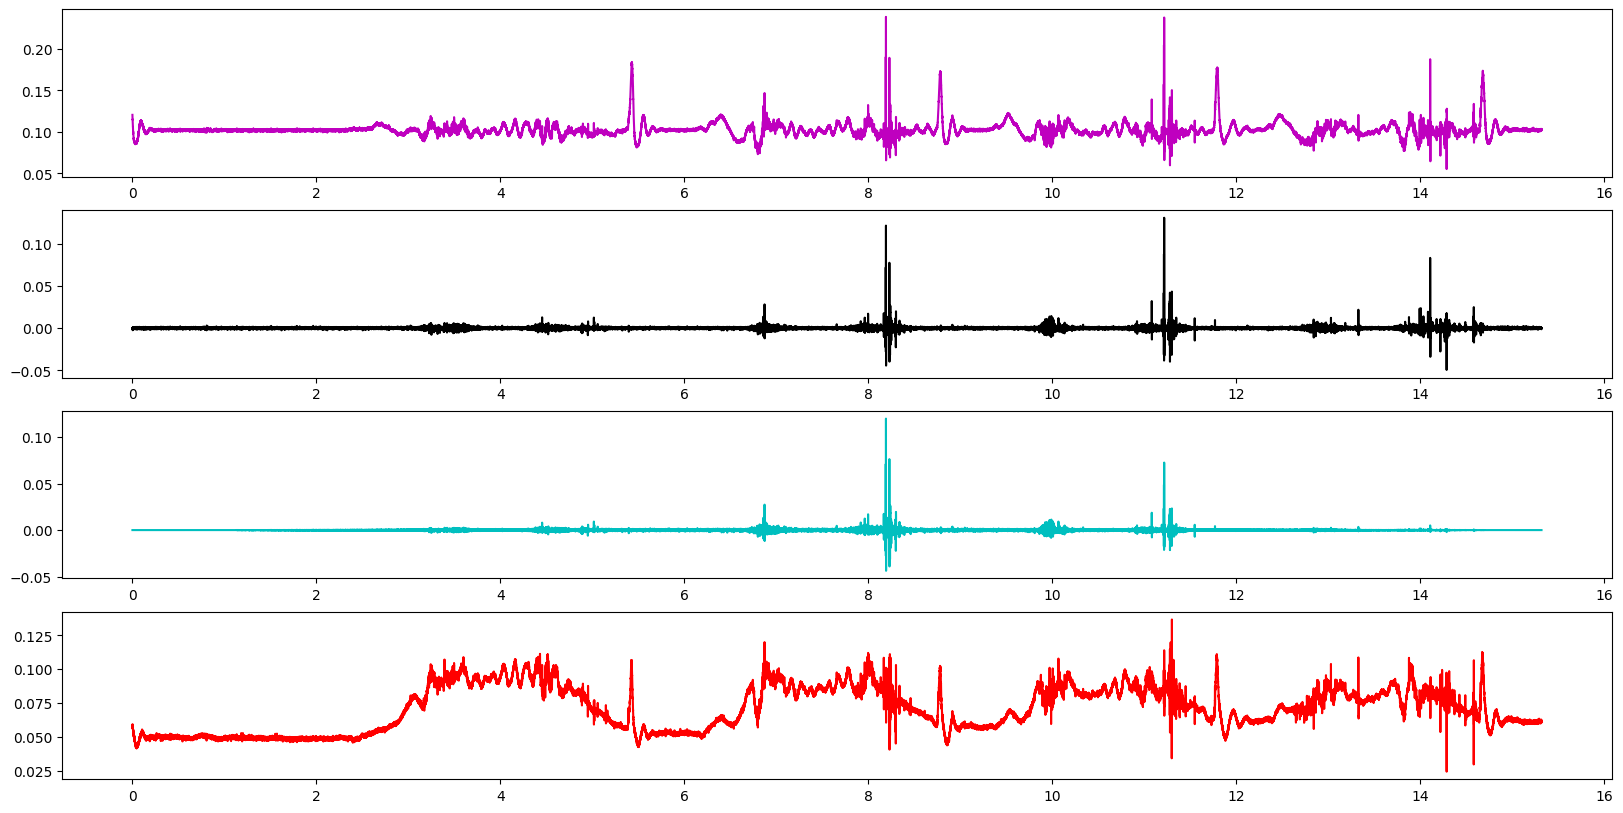

In [23]:

data_path = f"../../data/TalTech/test_{rep}.csv"
op = pd.read_csv(data_path)
print(op.head(10))

op["HIGAccel_Mag (g)"] =  op["HIGAccel_Mag (g)"] * conversion_factor

x = op["HIGAccel_Z (g)"] * conversion_factor

op_mag  = filter_signal(b,a, op['HIGAccel_Mag (g)'], "filtfilt")#amplitude_normal(u_op['mag']), "filtfilt")
# apply a hanning window to magnitude vector
op_mag_hann = apply_hanning(op_mag)
op_mag = op_mag 
op_mag_hann = op_mag_hann 

# simple graphs
fig, ax = plt.subplots(4,1, figsize=(20, 10))

time_2 = op["Time (s)"]

time_step = 1 / fs  # in seconds
time = np.arange(len(op['HIGAccel_Mag (g)'])) * time_step

ax[0].plot(time, op['HIGAccel_Mag (g)'], color="m")
ax[1].plot(time, op_mag, color="black")
ax[2].plot(time, op_mag_hann, color="c")
ax[3].plot(time, x, color="r")

# Power Spectrum
### 1. Welches method
### 2. Simple fft and square mag at each f

In [26]:
# functions
def compute_fft_mag(data, fs):
    T = 1/fs
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(data)))))
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) 
    N_r =len(mag)//2
    x = np.linspace(0.0, 1.0/(2.0*T), len(mag)//2).tolist()
    y = mag[:N_r]
    return x,y

# assumes a numpy arrray
def compute_power_spectrum(fft_mag):
    power = np.square(fft_mag)
    return power

In [28]:
# 2.simple fft

fftpoints =  len(op_mag)
op_x, op_fft = compute_fft_mag(op_mag, fs)
op_power = compute_power_spectrum(op_fft)
op_total_pwr =  round(np.sum(op_power),2)

print(f"total pwr op:   {op_total_pwr}")
op_int_total_pwr = np.trapezoid(op_power, op_x)
print(op_int_total_pwr)

total pwr op:   28714.81
1314.478239468819


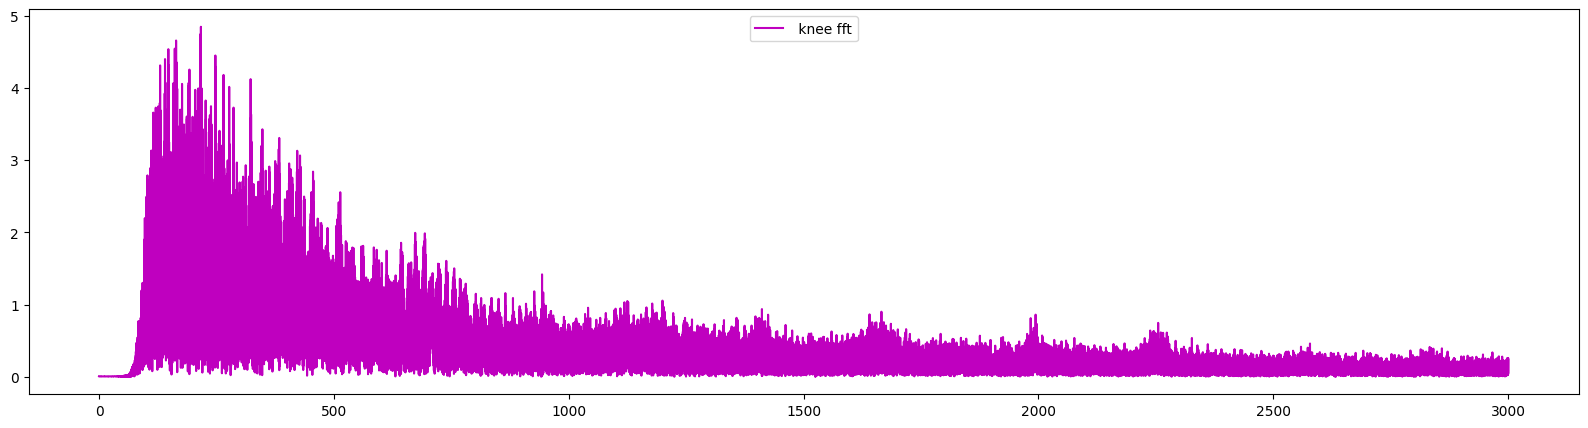

In [29]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

# add plots
ax.plot(op_x, op_fft, color="m", label=" knee fft")
ax.legend(loc='upper center')

In [50]:
# 1 welch

segment_length = 128 # Length of each segment
overlap = segment_length // 2  # 50% overlap
window = get_window('hann', segment_length)  # Hann window

# Compute the power spectral density or spectrum
op_w, op_psd = welch(op_mag_hann, fs=fs, window=window, nperseg=segment_length, noverlap=overlap, scaling='spectrum')
delta_f = fs / segment_length
print(f"frequency resolution is: {delta_f}")

frequency_range = (10, 3000)  # Frequency range for normalization
op_f_idx = np.logical_and(op_w >= frequency_range[0], op_w <= frequency_range[1])
# Normalize the PSD within the desired frequency range
op_psd_norm = op_psd / np.trapezoid(op_psd[op_f_idx], op_w[op_f_idx])

op_psd_avg = np.mean(op_psd_norm, axis=0)

# avg
print(f"avg psd op:    {op_psd_avg}")
# total power 
op_w_total_pwr = np.trapezoid(op_psd, op_w)

print(f"total pwr op:   {op_w_total_pwr}")

op_sp_f, op_sp_t, op_Sxx = spectrogram(op_mag, fs=fs, window=window, nperseg=segment_length, noverlap=overlap, scaling='density')

frequency resolution is: 46.875
avg psd op:    0.00034317070166401347
total pwr op:   0.00019792005740101905


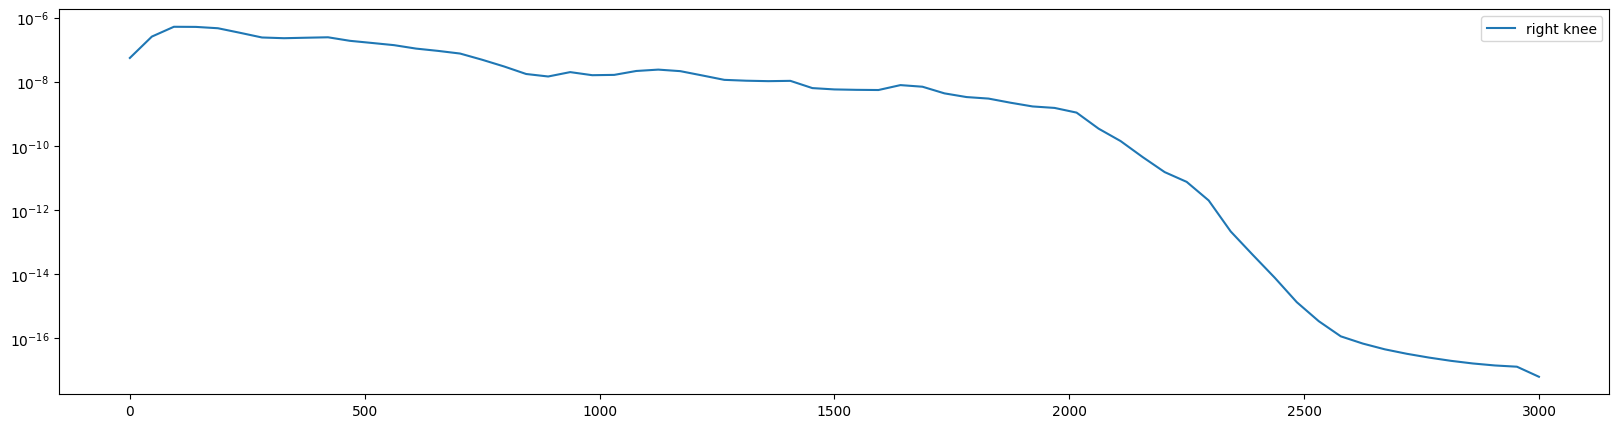

In [51]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax.semilogy(op_w, op_psd, label='right knee')
ax.legend()


In [44]:
# compute short time fourier transform
# STFT
segment_length = 4096  # Number of samples per segment
overlap = 50  # Overlap of 100 samples
window = hann(segment_length)

# returns the magntidue and not power directly
op_f, op_t, op_Zxx = stft(op_mag, fs=fs, window=window,  nperseg=segment_length, noverlap=overlap)
# compute power from stft
op_pwr = np.abs(op_Zxx)**2

# F Bands
band1 = (100, 250)  # Frequency band 1: 50–250 Hz
band2 = (250, 500)  # Frequency band 2: 250–450 Hz

# Find indices corresponding to the desired frequency bands
op_band1_indices = np.logical_and(op_f >= band1[0], op_f < band1[1])
op_band2_indices = np.logical_and(op_f >= band2[0], op_f < band2[1])

# Sum the power in the specified bands
op_P1 = np.sum(op_pwr[op_band1_indices, :], axis=0)
op_P2 = np.sum(op_pwr[op_band2_indices, :], axis=0)

total_op_P1 = np.sum(op_pwr[op_band1_indices, :])  # Total power in 50-250 Hz across all time
total_op_P2 = np.sum(op_pwr[op_band2_indices, :])  # Total power in 250-450 Hz across all time

print(f"Total Power in 50-250 Hz (op P1): {total_op_P1}")
print(f"Total Power in 250-450 Hz (op P2): {total_op_P2}")

Total Power in 50-250 Hz (op P1): 3.4686831040705645e-05
Total Power in 250-450 Hz (op P2): 2.6663503529358595e-05


(0.0, 3000.0)

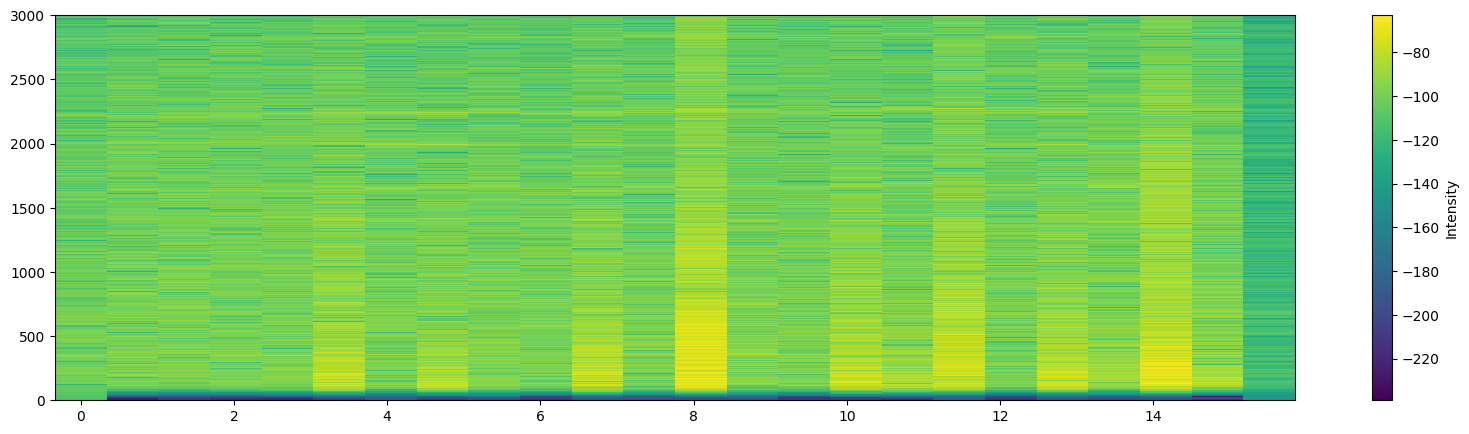

In [45]:
p_Zxx = 10 * np.log10(np.abs(op_pwr))

fig, ax = plt.subplots(1,1, figsize=(20, 5))
cax = ax.pcolormesh(op_t, op_f, p_Zxx, shading='auto', cmap="viridis")
fig.colorbar(cax, ax=ax, label='Intensity')
ax.set_ylim(0, fs/2)

200


(50.0, 3000.0)

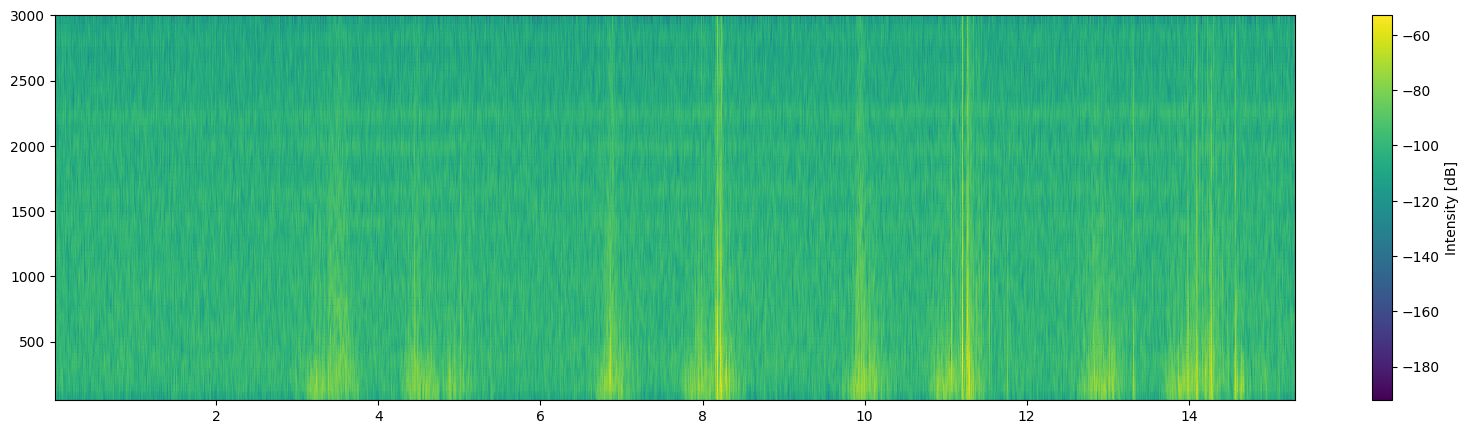

In [41]:

f_bins = 101
f_bins_input = 2 * (f_bins-1)
print(f_bins_input)

segment_length = 100  # Number of samples per segment
overlap = 80  # Overlap of 100 samples
window = hann(segment_length)

# nfft degaults to segment length if none is applied (window is hann but default is tukey (this doesnt seem to make a difference)
# directly returns the power spectrum
f, t, Sxx = spectrogram(op_mag, fs=fs, window=window, nperseg=segment_length, noverlap=overlap)

fig, ax = plt.subplots(1,1, figsize=(20, 5))

cax = ax.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud', )

fig.colorbar(cax, ax=ax, label='Intensity [dB]')

ax.set_ylim(50, fs/2)

(100.0, 250.0)

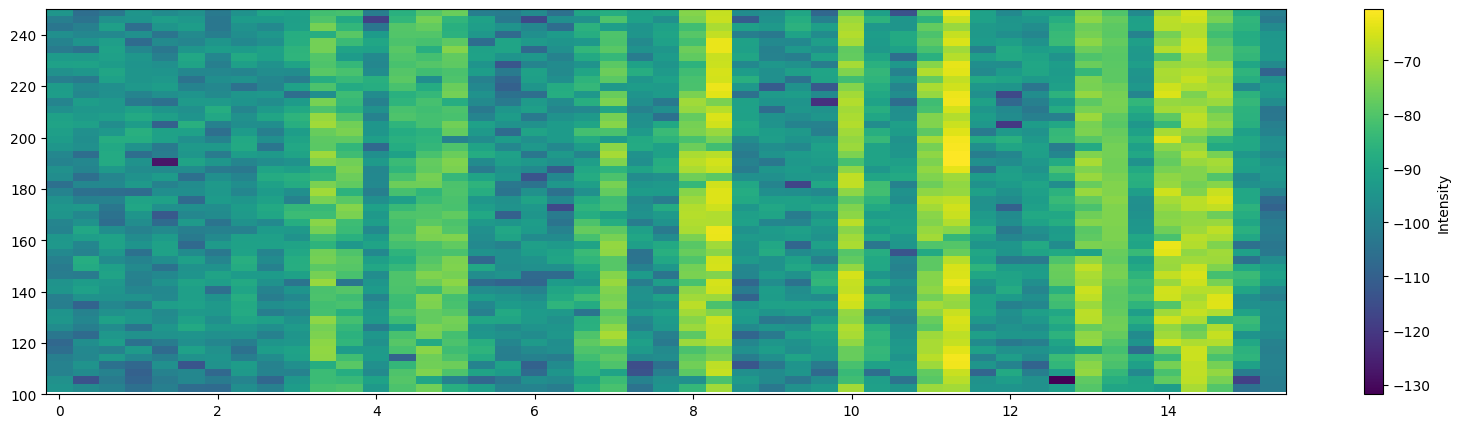

In [42]:
p_Zxx = 10 * np.log10(np.abs(op_pwr))

#filter a frequency band
band1 = (100, 250)  # Frequency band 1: 50–250 Hz
freq_mask = (op_f >= band1[0]) & (op_f <= band1[1])  # Create a boolean mask
frequencies_filtered = op_f[freq_mask]  # Apply mask to frequencies
Sxx_dB_filtered = p_Zxx[freq_mask, :]  # Apply mask to spectrogram data

fig, ax = plt.subplots(1,1, figsize=(20, 5))
cax = ax.pcolormesh(op_t, frequencies_filtered, Sxx_dB_filtered, shading='auto', cmap="viridis")
fig.colorbar(cax, ax=ax, label='Intensity')
ax.set_ylim(band1[0], band1[1])

(250.0, 500.0)

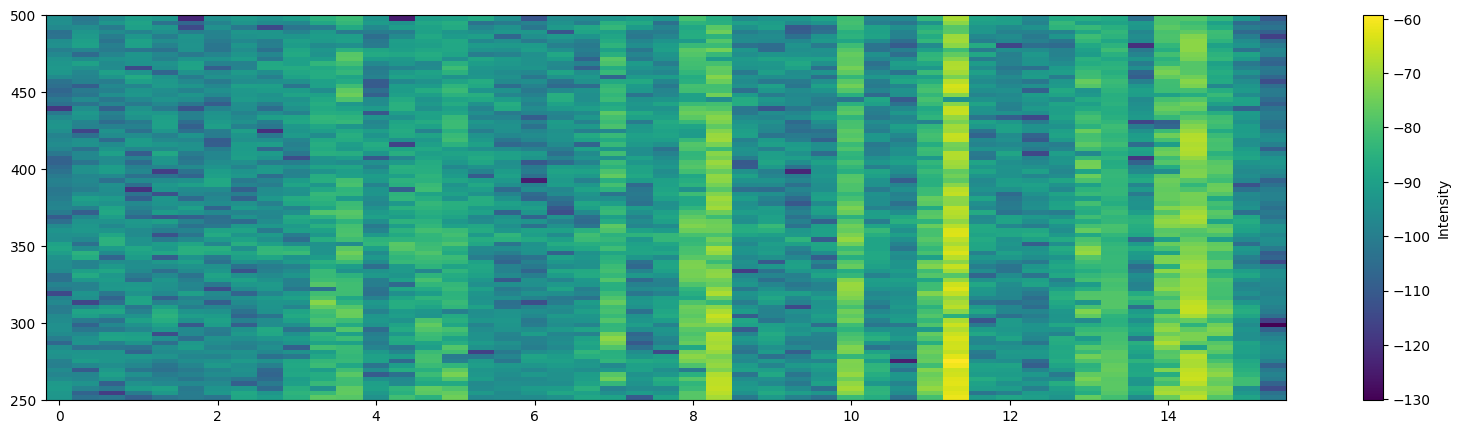

In [43]:
p_Zxx = 10 * np.log10(np.abs(op_pwr))

#filter a frequency band
band1 = (250, 500)  # Frequency band 1: 50–250 Hz
freq_mask = (op_f >= band1[0]) & (op_f <= band1[1])  # Create a boolean mask
frequencies_filtered = op_f[freq_mask]  # Apply mask to frequencies
Sxx_dB_filtered = p_Zxx[freq_mask, :]  # Apply mask to spectrogram data

fig, ax = plt.subplots(1,1, figsize=(20, 5))
cax = ax.pcolormesh(op_t, frequencies_filtered, Sxx_dB_filtered, shading='auto', cmap="viridis")
fig.colorbar(cax, ax=ax, label='Intensity')
ax.set_ylim(band1[0], band1[1])